In [1]:
import tensorflow as tf
import tensorflow_io as tfio
#import tensorflow_hub as hub
import numpy as np
import csv
import io
import librosa
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Audio
import scipy.io
import PIL.Image

In [2]:
# Modified from tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer

In [3]:
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def preprocess(mels):
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    return img

In [4]:
def preprocess_spectrogram(img_arr):
    max_dim = 512
    img = img_arr
    
    # convert into 3D
    img = img.reshape((img.shape[0], img.shape[1], 1))
    img = np.tile(img, 3)
    
#     print('Image Shape', img.shape)
    img = tf.image.convert_image_dtype(img, tf.float32)
#     print('Image shape2', img.shape)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
#     print('Shape', shape)
    long_dim = max(shape)
#     print('Longest Dim', long_dim)
    
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
#     print('New Shape', new_shape)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
#     print('Final:', img.shape)
    return img

In [5]:
def load_img(path_to_img):
    """Preprocessing for VGG"""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
#     print(img.shape)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
#     print(shape)
    long_dim = max(shape)
#     print(long_dim)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
#     print(shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        plt.imshow(image)
    if title:
        plt.title(title)

In [6]:
import pandas as pd
df_test_metadata = pd.read_csv('test_vox1_metadata.csv')

In [7]:
df_test_metadata

,Unnamed: 0,VoxCeleb1 ID,VGGFace1 ID,Gender,Nationality,Set,full_paths
0,269,id10270,Eartha_Kitt,f,USA,test,./data/spmel_test/id10270/x6uYqmx31kE_00002.npy
1,270,id10271,Ed_Westwick,m,UK,test,./data/spmel_test/id10271/zWyD72sHVwA_00001.npy
2,271,id10272,Eddie_Griffin,m,USA,test,./data/spmel_test/id10272/wb6ligRbbZ4_00001.npy
3,272,id10273,Eddie_Izzard,m,UK,test,./data/spmel_test/id10273/xN2fSTQHHkw_00002.npy
4,273,id10274,Eddie_Kaye_Thomas,m,USA,test,./data/spmel_test/id10274/xbGp2KSUr0E_00001.npy
5,274,id10275,Eddie_McClintock,m,USA,test,./data/spmel_test/id10275/mWZ3l5OoyVI_00002.npy
6,275,id10276,Edgar_Wright,m,UK,test,./data/spmel_test/id10276/3vWez3baO60_00002.npy
7,276,id10277,Eduardo_Noriega,m,Spain,test,./data/spmel_test/id10277/cELY3LdIo-0_00003.npy
8,277,id10278,Edward_Asner,m,USA,test,./data/spmel_test/id10278/y990f6UiEEM_00001.npy
9,278,id10279,Efren_Ramirez,m,USA,test,./data/spmel_test/id10279/4Q1IvdayPR8_00014.npy


/Users/niralshah/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


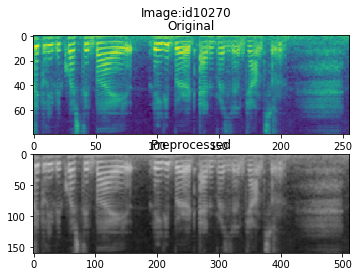

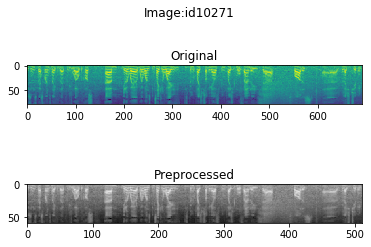

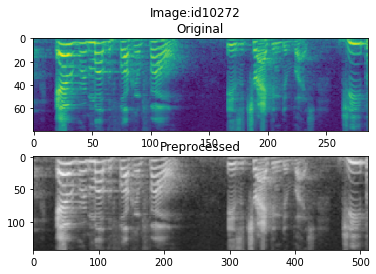

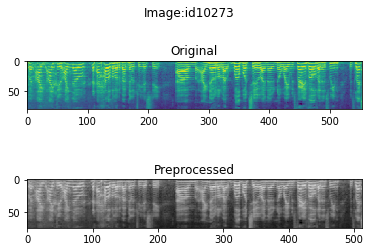

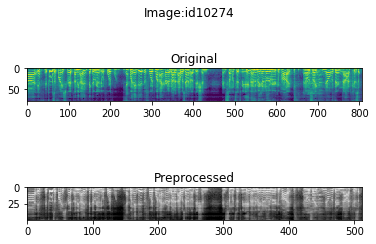

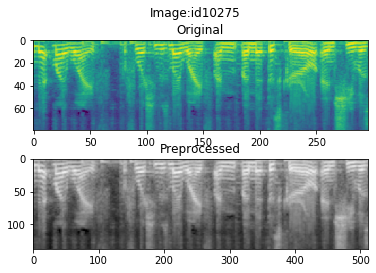

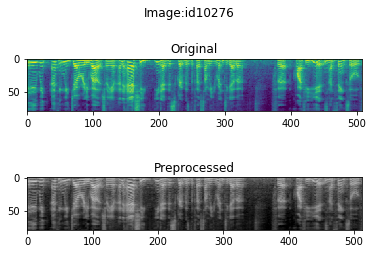

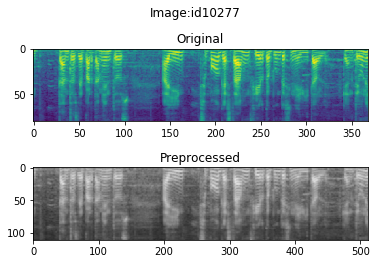

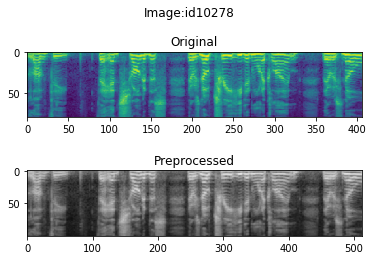

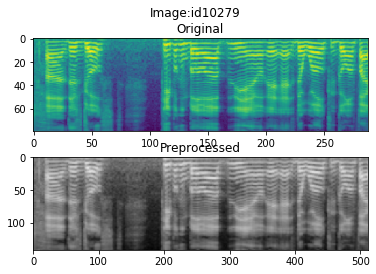

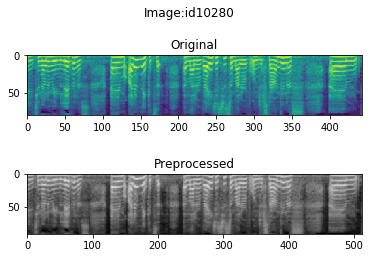

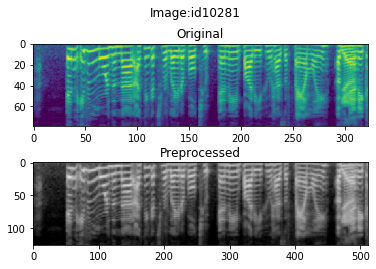

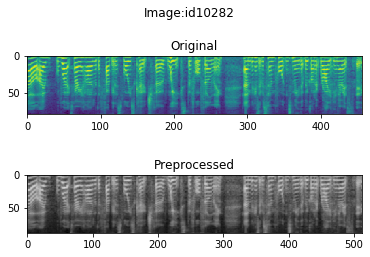

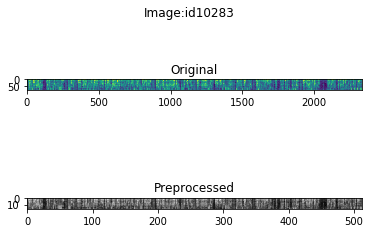

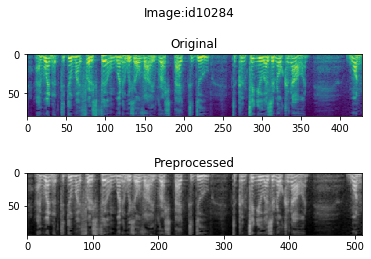

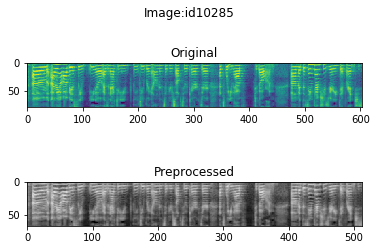

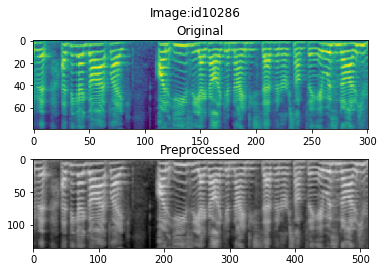

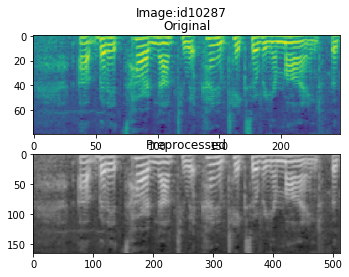

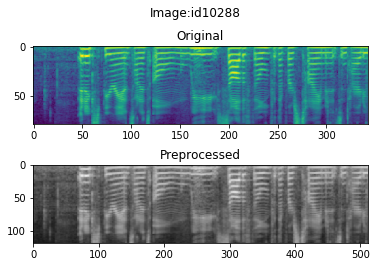

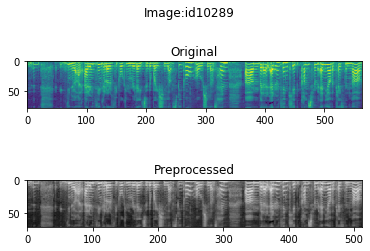

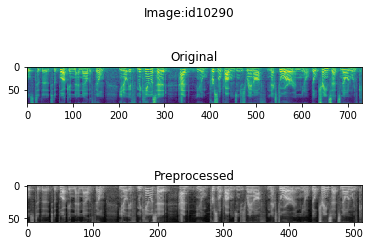

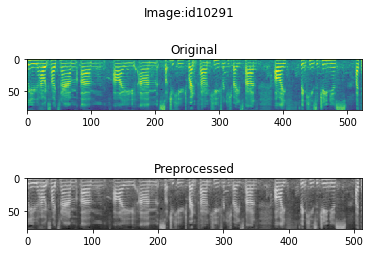

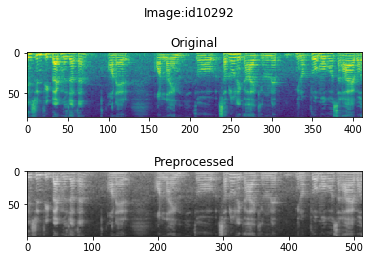

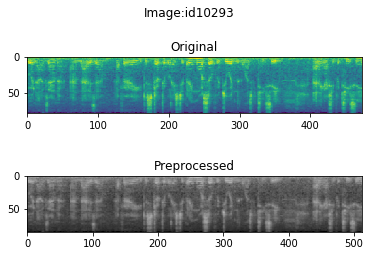

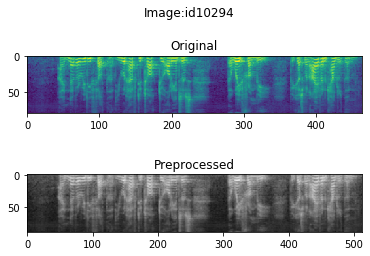

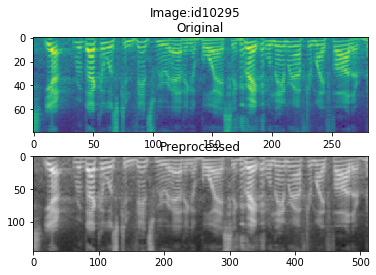

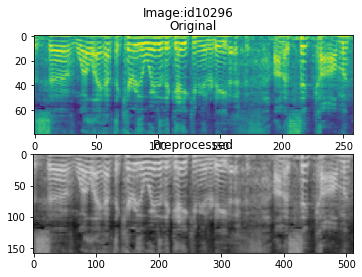

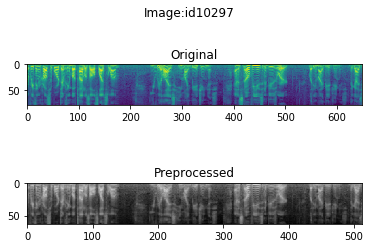

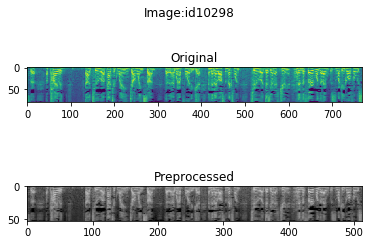

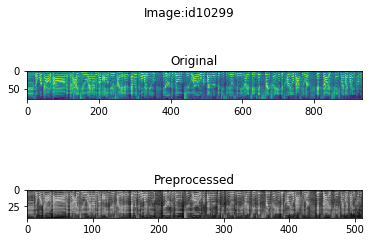

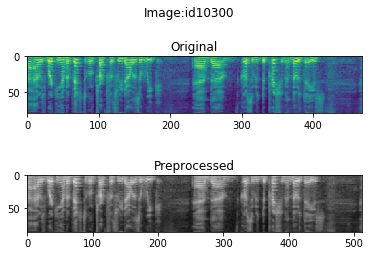

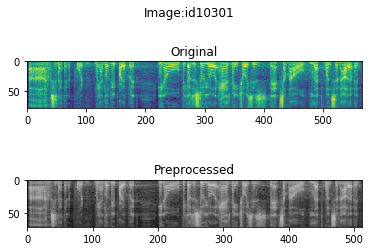

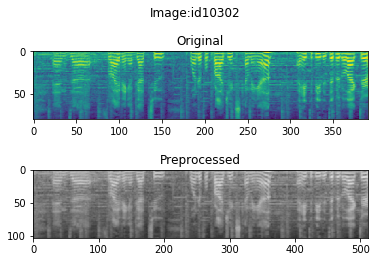

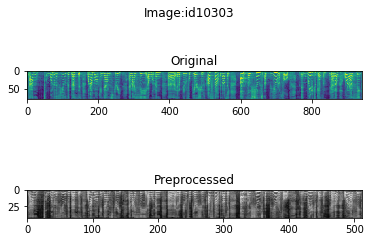

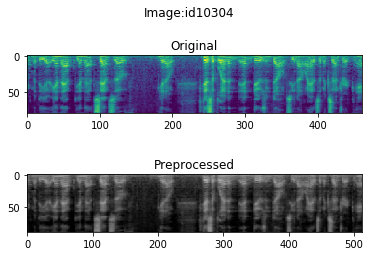

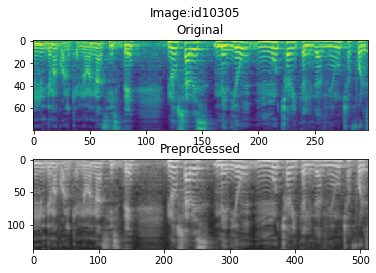

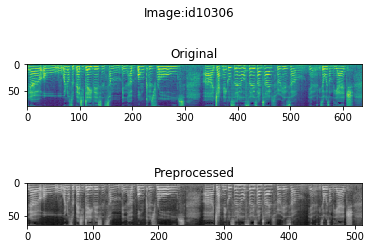

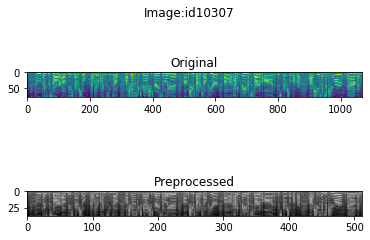

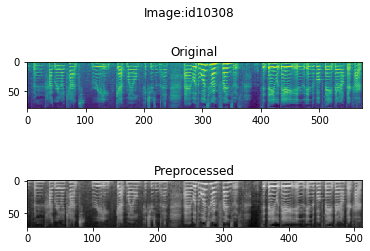

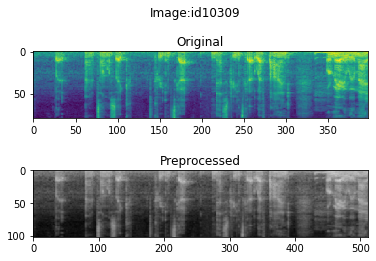

In [8]:
images = {}
for row in df_test_metadata.iterrows():
    row_item = row[1]
    user_id = row_item['VoxCeleb1 ID']
    images[user_id] = preprocess_spectrogram(np.load(row_item['full_paths']).T)
    fig, ax = plt.subplots(2,1)
    fig.suptitle(f'Image:{user_id}')
    ax[0].imshow(np.load(row_item['full_paths']).T)
    ax[0].set_title('Original')
    
    ax[1].imshow(images[user_id][0])
    ax[1].set_title('Preprocessed')

In [9]:
import itertools
image_combinations = list(map(dict, itertools.combinations(
    images.items(), 2)))

In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [11]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    #get activations from layers we're interested in
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False 
        
    def call(self, inputs):
        """Expects float input in [0,1]"""
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name,value in zip(self.content_layers, content_outputs)}
        style_dict = {
            style_name:value 
            for style_name, value
            in zip(self.style_layers, style_outputs)
        }
        return {'content': content_dict, 'style': style_dict}

In [16]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [17]:
def tensor_to_audio(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    tensor = tf.reduce_mean(tensor,axis=-1)
    audio_arr = librosa.feature.inverse.mel_to_audio(tensor.numpy().astype(np.float64), sr=16000, n_fft=1024, hop_length=256, n_iter=64)
    return audio_arr

In [18]:
def get_audio_data(pair):
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    image = None
    style_weight=1e-2
    content_weight=1e4

    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    def style_content_loss(outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        loss = style_loss + content_loss
        return loss

    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
    
    content_image_id, style_image_id = pair.keys()
    content_image = pair[content_image_id]
    style_image = pair[style_image_id]
    
    extractor = StyleContentModel(style_layers, content_layers)
    
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    if image is None:
        image = tf.Variable(content_image)
    else:
        image.assign(content_image)
    audio_arr = None
    spec_img = None
    for n in range(epochs):
        for m in range(steps_per_epoch):
            train_step(image)
            print(".", end='')
#         display.clear_output(wait=True)
        spec_img = tensor_to_image(image)
        display.display(spec_img)
        audio_arr = tensor_to_audio(image)
        print("Train step: {}".format(m))
    filename = f'{content_image_id}x{style_image_id}_vgg19'
    if audio_arr is not None:
#         display.display(Audio(audio_arr, rate=16000))
        scipy.io.wavfile.write(filename+'.wav', 16000, audio_arr)
#         print(np.array(spec_img).shape)
        plt.imsave(filename+'.png', np.array(spec_img)[0])

id10275xid10276
..........Train step: 9
..........Train step: 9
..........Train step: 9
id10275xid10277


KeyboardInterrupt: 

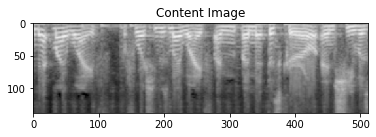

In [27]:
epochs = 3 # 10
steps_per_epoch = 10 #100
prev_pair = None
count = 0

for pair in image_combinations:
    content_image_id, style_image_id = pair.keys()
    if content_image_id in ['id10271', 'id10270', 'id10272', 'id10273','id10274']:
        continue
    if prev_pair is None:
        prev_pair = content_image_id
    elif content_image_id != prev_pair :
        prev_pair = content_image_id
        count = 0
    else:
        count += 1
    if count >= 9:
        continue
    print(f'{content_image_id}x{style_image_id}')
    plt.title('Content Image')
    plt.imshow(pair[content_image_id][0,:,:, :])
    get_audio_data(pair)